   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   ---------------------------------------- 2.9/2.9 MB 23.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ----------------------------------- ---- 11.5/12.9 MB 55.5 MB/s eta 0:00:01
   ---------------------------------------- 12.9/12.9 MB 50.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 38.1 MB/s eta 0:00:00


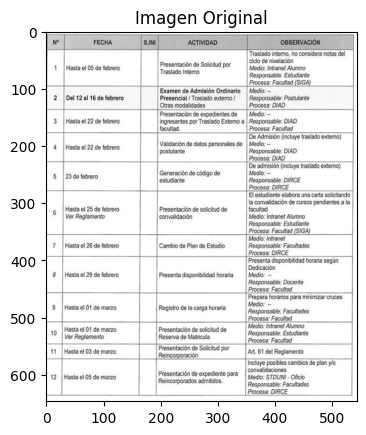

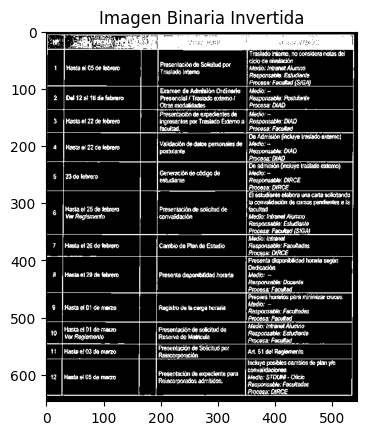

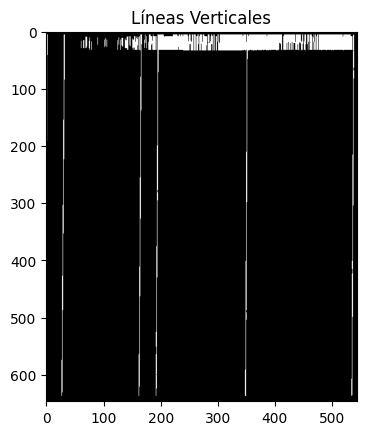

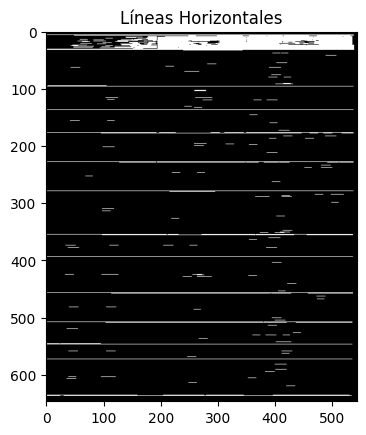

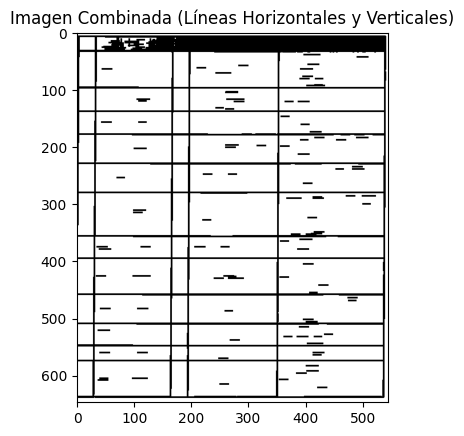

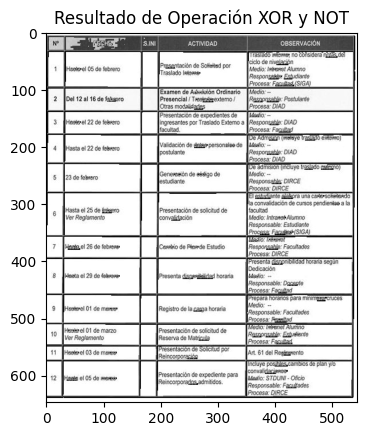

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompleteArchivo Excel generado: output_sophisticated.xlsx


In [1]:
# Instalar e importar librerías necesarias
!pip install pytesseract opencv-python-headless Pillow openpyxl easyocr torch torchvision

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
try:
    from PIL import Image
except ImportError:
    from PIL import Image
import pytesseract
import easyocr  # Importar EasyOCR para reconocimiento de texto
import torch
import torchvision

# Asegurarse de que Tesseract esté instalado
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Verificar si la ruta de la imagen es correcta
file = r'C:\xampp\htdocs\php5\content\Proyecto\imagen-tabla.JPG'
if not os.path.exists(file):
    raise FileNotFoundError(f"La imagen no se encontró en la ruta especificada: {file}")

# Leer la imagen y mostrar su información
img = cv2.imread(file, 0)
if img is None:
    raise ValueError("La imagen no pudo ser cargada. Verifique la ruta y el formato del archivo.")

# Mostrar la imagen original
plt.imshow(img, cmap='gray')
plt.title('Imagen Original')
plt.show()

# Umbralizar la imagen a binaria
thresh, img_bin = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# Invertir la imagen binaria
img_bin = 255 - img_bin
plt.imshow(img_bin, cmap='gray')
plt.title('Imagen Binaria Invertida')
plt.show()

# Definir los kernels para detectar líneas verticales y horizontales
kernel_len = np.array(img).shape[1] // 100
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

# Detectar y guardar las líneas verticales
image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)
plt.imshow(vertical_lines, cmap='gray')
plt.title('Líneas Verticales')
plt.show()

# Detectar y guardar las líneas horizontales
image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)
plt.imshow(horizontal_lines, cmap='gray')
plt.title('Líneas Horizontales')
plt.show()

# Combinar las líneas horizontales y verticales
ing_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
ing_vh = cv2.erode(~ing_vh, kernel, iterations=2)
thresh, ing_vh = cv2.threshold(ing_vh, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.imshow(ing_vh, cmap='gray')
plt.title('Imagen Combinada (Líneas Horizontales y Verticales)')
plt.show()

# Operación XOR y NOT para obtener los componentes conectados
bitxor = cv2.bitwise_xor(img, ing_vh)
bitnot = cv2.bitwise_not(bitxor)
plt.imshow(bitnot, cmap='gray')
plt.title('Resultado de Operación XOR y NOT')
plt.show()

# Detección de contornos para la detección de cajas
contours, hierarchy = cv2.findContours(ing_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Función para ordenar contornos
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0  # Ordenar por el eje x por defecto
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1  # Ordenar por el eje y
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes), key=lambda b: b[1][i], reverse=reverse))
    return (cnts, boundingBoxes)

# Ordenar todos los contornos de arriba a abajo
contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")

# Crear una lista de las alturas de todas las cajas delimitadoras
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
mean = np.mean(heights)

# Crear una lista para almacenar todas las cajas
box = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w >= 100 and h >= 20):  # Ajustar el filtro de tamaño según la imagen
        box.append((x, y, w, h))

# Crear listas para filas y columnas
row = []
column = []
previous = None
for i in range(len(box)):
    if i == 0:
        column.append(box[i])
        previous = box[i]
    else:
        if box[i][1] <= previous[1] + mean / 2:
            column.append(box[i])
            previous = box[i]
            if i == len(box) - 1:
                row.append(column)
        else:
            row.append(column)
            column = []
            previous = box[i]
            column.append(box[i])

# Calcular el número máximo de celdas en una fila
countcol = max([len(r) for r in row])

# Obtener el centro de cada columna
center = [int(r[0] + r[2] / 2) for r in row[0]]
center = np.array(center)
center.sort()

# Organizar las celdas en su posición correcta
finalboxes = []
for i in range(len(row)):
    lis = [[] for _ in range(countcol)]
    for j in range(len(row[i])):
        diff = abs(center - (row[i][j][0] + row[i][j][2] / 4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)

# Aplicar OCR a cada celda usando EasyOCR para mejorar la precisión
reader = easyocr.Reader(['en'])  # Inicializar el lector de EasyOCR
outer = []
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner = ''
        if len(finalboxes[i][j]) == 0:
            outer.append('')
        else:
            for k in range(len(finalboxes[i][j])):
                y, x, w, h = finalboxes[i][j][k]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg, 2, 2, 2, 2, cv2.BORDER_CONSTANT, value=[255, 255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel, iterations=1)
                erosion = cv2.erode(dilation, kernel, iterations=2)
                # Usar EasyOCR para obtener el texto de la celda
                result = reader.readtext(erosion)
                for res in result:
                    inner += " " + res[1]
            outer.append(inner)

# Crear un DataFrame de los resultados obtenidos
dataframe = pd.DataFrame(np.array(outer).reshape(len(row), countcol))

# Configurar el formato del archivo Excel con opciones adicionales para mejorar la presentación
df_style = dataframe.style.set_properties(**{'text-align': 'left', 'border': '1px solid black'}).set_table_styles(
    [{'selector': 'th', 'props': [('font-weight', 'bold'), ('text-align', 'center'), ('background-color', '#f0f0f0')]}]
)

# Guardar el DataFrame en un archivo Excel sofisticado
df_style.to_excel("output_sophisticated.xlsx", index=False, engine='openpyxl', freeze_panes=(1, 0))

print("Archivo Excel generado: output_sophisticated.xlsx")